In [3]:
import keras
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [4]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

W0705 08:09:50.324591 140577428494144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0705 08:09:50.757723 140577428494144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0705 08:09:50.810677 140577428494144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0705 08:09:50.901830 140577428494144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0705 08:09:51.932624 140577428494144 deprecation_wrapp

In [5]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [7]:
base_dir = '/home/jose/Desktop/ship_dataset_6500_1000_625_yacht_tanker'

In [8]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [9]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [10]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [11]:
train_features, train_labels = extract_features(train_dir, 6500)

Found 13000 images belonging to 2 classes.


In [12]:
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 2000 images belonging to 2 classes.


In [16]:
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.


In [17]:
train_features = np.reshape(train_features, (6500, 4 * 4 * 512))

In [18]:
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))

In [19]:
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [20]:
from keras import models
from keras import layers
from keras import optimizers

In [21]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

W0705 08:35:15.547384 140577428494144 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

W0705 08:35:25.421784 140577428494144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0705 08:35:25.430860 140577428494144 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 6500 samples, validate on 1000 samples
Epoch 1/30
6500/6500 [==============================] - 10s 2ms/step - loss: 0.3691 - acc: 0.8369 - val_loss: 0.2222 - val_acc: 0.9270
Epoch 2/30
6500/6500 [==============================] - 9s 1ms/step - loss: 0.2039 - acc: 0.9232 - val_loss: 0.1728 - val_acc: 0.9400
Epoch 3/30
6500/6500 [==============================] - 9s 1ms/step - loss: 0.1641 - acc: 0.9389 - val_loss: 0.1563 - val_acc: 0.9500
Epoch 4/30
6500/6500 [==============================] - 9s 1ms/step - loss: 0.1470 - acc: 0.9432 - val_loss: 0.1480 - val_acc: 0.9490
Epoch 5/30
6500/6500 [==============================] - 9s 1ms/step - loss: 0.1365 - acc: 0.9489 - val_loss: 0.1425 - val_acc: 0.9520
Epoch 6/30
6500/6500 [==============================] - 9s 1ms/step - loss: 0.1294 - acc: 0.9512 - val_loss: 0.1343 - val_acc: 0.9530
Epoch 7/30
6500/6500 [==============================] - 9s 1ms/step - loss: 0.1191 - acc: 0.9549 - val_loss: 0.1341 - val_acc: 0.9550
Epoch 8/30
65

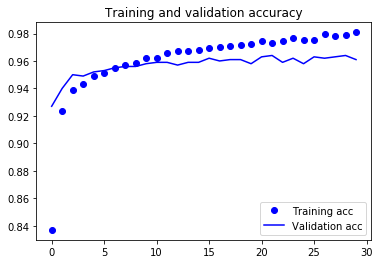

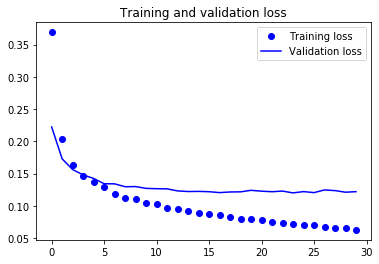

In [23]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Feature extraction start

In [23]:
from keras import models
from keras import layers

In [24]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [25]:
conv_base.trainable = False

In [26]:
from keras.preprocessing.image import ImageDataGenerator

In [27]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [28]:
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)


In [29]:
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 13000 images belonging to 2 classes.


In [30]:
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.


In [31]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [34]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/30
 - 239s - loss: 0.5350 - acc: 0.7550 - val_loss: 0.4140 - val_acc: 0.8320
Epoch 2/30
 - 247s - loss: 0.4122 - acc: 0.8290 - val_loss: 0.3009 - val_acc: 0.9030
Epoch 3/30
 - 246s - loss: 0.3593 - acc: 0.8550 - val_loss: 0.2581 - val_acc: 0.9040
Epoch 4/30
 - 257s - loss: 0.3194 - acc: 0.8755 - val_loss: 0.2302 - val_acc: 0.9270
Epoch 5/30
 - 248s - loss: 0.2926 - acc: 0.8875 - val_loss: 0.2449 - val_acc: 0.9000
Epoch 6/30
 - 246s - loss: 0.2894 - acc: 0.8895 - val_loss: 0.2041 - val_acc: 0.9180
Epoch 7/30
 - 249s - loss: 0.2868 - acc: 0.8840 - val_loss: 0.1894 - val_acc: 0.9360
Epoch 8/30
 - 243s - loss: 0.2397 - acc: 0.9120 - val_loss: 0.1636 - val_acc: 0.9410
Epoch 9/30
 - 243s - loss: 0.2401 - acc: 0.9075 - val_loss: 0.1798 - val_acc: 0.9330
Epoch 10/30
 - 243s - loss: 0.2595 - acc: 0.8920 - val_loss: 0.1626 - val_acc: 0.9400
Epoch 11/30
 - 247s - loss: 0.2443 - acc: 0.8990 - val_loss: 0.1867 - val_acc: 0.9240
Epoch 12/30
 - 247s - loss: 0.2258 - acc: 0.9145 - val_loss: 0.

In [35]:
model.save('yatch_tanker_feature_extraction_1.h5')

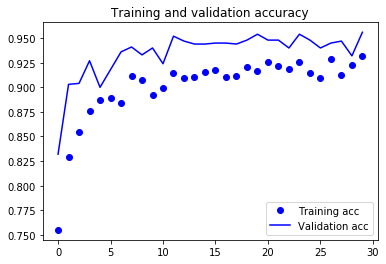

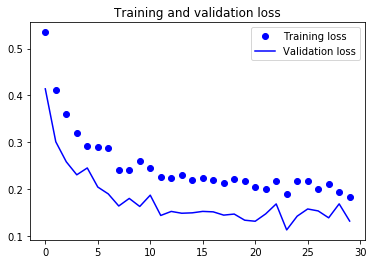

In [36]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fine-tuning start

In [37]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [32]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [33]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [34]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 251s 3s/step - loss: 0.4220 - acc: 0.8100 - val_loss: 0.2212 - val_acc: 0.9140
Epoch 2/100
100/100 [==============================] - 253s 3s/step - loss: 0.2745 - acc: 0.8895 - val_loss: 0.1684 - val_acc: 0.9500
Epoch 3/100
100/100 [==============================] - 252s 3s/step - loss: 0.2244 - acc: 0.9140 - val_loss: 0.1279 - val_acc: 0.9580
Epoch 4/100
100/100 [==============================] - 252s 3s/step - loss: 0.1904 - acc: 0.9305 - val_loss: 0.1487 - val_acc: 0.9450
Epoch 5/100
100/100 [==============================] - 253s 3s/step - loss: 0.1979 - acc: 0.9235 - val_loss: 0.1756 - val_acc: 0.9260
Epoch 6/100
100/100 [==============================] - 253s 3s/step - loss: 0.1887 - acc: 0.9285 - val_loss: 0.0971 - val_acc: 0.9680
Epoch 7/100
100/100 [==============================] - 252s 3s/step - loss: 0.1570 - acc: 0.9450 - val_loss: 0.1182 - val_acc: 0.9540
Epoch 8/100
100/100 [==============================] - 252s 3s

Epoch 62/100
100/100 [==============================] - 252s 3s/step - loss: 0.1051 - acc: 0.9665 - val_loss: 0.0775 - val_acc: 0.9770
Epoch 63/100
100/100 [==============================] - 252s 3s/step - loss: 0.1006 - acc: 0.9635 - val_loss: 0.0679 - val_acc: 0.9750
Epoch 64/100
100/100 [==============================] - 252s 3s/step - loss: 0.0965 - acc: 0.9680 - val_loss: 0.0920 - val_acc: 0.9790
Epoch 65/100
100/100 [==============================] - 252s 3s/step - loss: 0.0920 - acc: 0.9675 - val_loss: 0.1207 - val_acc: 0.9680
Epoch 66/100
100/100 [==============================] - 252s 3s/step - loss: 0.0982 - acc: 0.9645 - val_loss: 0.0799 - val_acc: 0.9730
Epoch 67/100
100/100 [==============================] - 252s 3s/step - loss: 0.0794 - acc: 0.9725 - val_loss: 0.1274 - val_acc: 0.9700
Epoch 68/100
100/100 [==============================] - 258s 3s/step - loss: 0.0919 - acc: 0.9645 - val_loss: 0.0816 - val_acc: 0.9790
Epoch 69/100
100/100 [==============================] -

In [35]:
model.save('yatch_tanker_fine_tuning_1.h5')

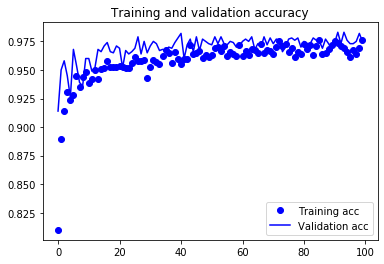

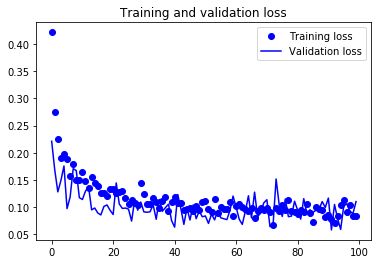

In [38]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

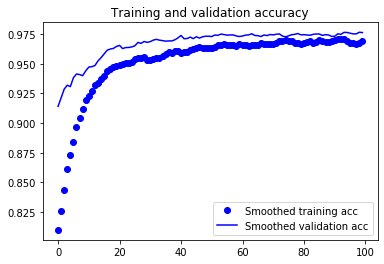

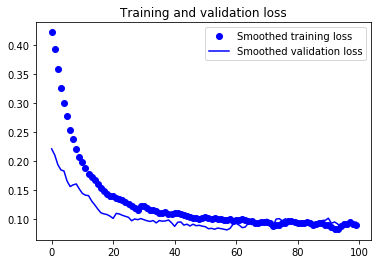

In [39]:

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [40]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 2000 images belonging to 2 classes.
test acc: 0.9779999947547913
